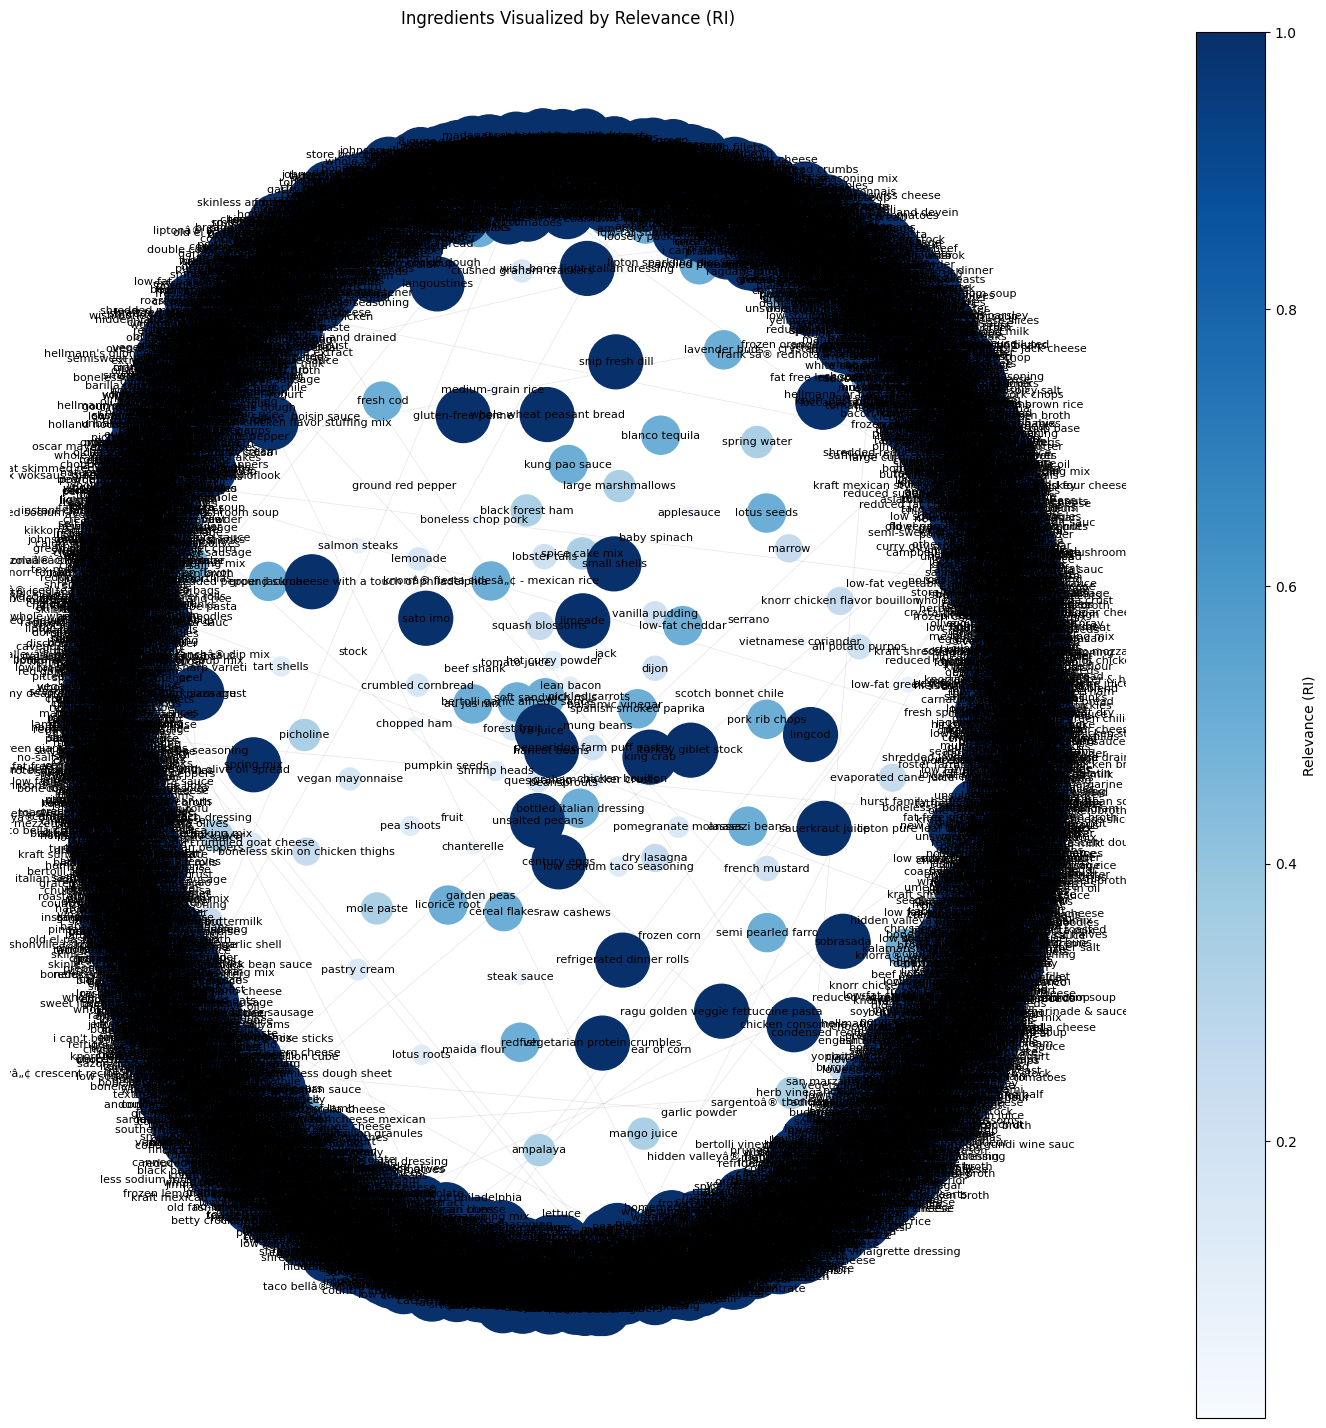

In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# --- Load ingredient relevance file ---
ri_df = pd.read_csv("ingredient_relevance.csv")
ri_df["Ingredient"] = ri_df["Ingredient"].str.strip().str.lower()

# --- Build graph ---
G = nx.Graph()
for _, row in ri_df.iterrows():
    G.add_node(row["Ingredient"], relevance=row["Relevance (RI)"])

# --- Node sizes and colors based on relevance ---
relevance_values = np.array([data['relevance'] for _, data in G.nodes(data=True)])
cmap = cm.Blues
norm = mcolors.Normalize(vmin=relevance_values.min(), vmax=relevance_values.max())
node_colors = cmap(norm(relevance_values))
node_sizes = relevance_values * 1500

# --- Layout ---
pos = nx.spring_layout(G, seed=42)

# --- Plot ---
fig, ax = plt.subplots(figsize=(18,18))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Optional: connect top ingredients for visualization
top_ingredients = ri_df.head(50)["Ingredient"].tolist()
edges = [(top_ingredients[i], top_ingredients[i+1]) for i in range(len(top_ingredients)-1)]
nx.draw_networkx_edges(G, pos, edgelist=edges, alpha=0.2, width=0.5, edge_color='gray', ax=ax)

# --- Add colorbar properly ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(relevance_values)
fig.colorbar(sm, ax=ax, label='Relevance (RI)')

plt.title("Ingredients Visualized by Relevance (RI)")
plt.axis('off')
plt.show()


The five relations are used to measure ingredient relevance in different ways:

1.Inverse (1/FI): Highlights rare ingredients, giving higher scores to less frequent items.

2.Linear (FI): Shows raw frequency, emphasizing common ingredients.

3.Logarithmic (log(1+FI)): Reduces the impact of very frequent ingredients, making the scale less extreme.

4.Exponential decay (exp(-0.01*FI)): Quickly down-weights frequent ingredients, focusing on uniqueness.

5.TF-IDF style: Balances frequency with distinctiveness, inspired by text analysis.

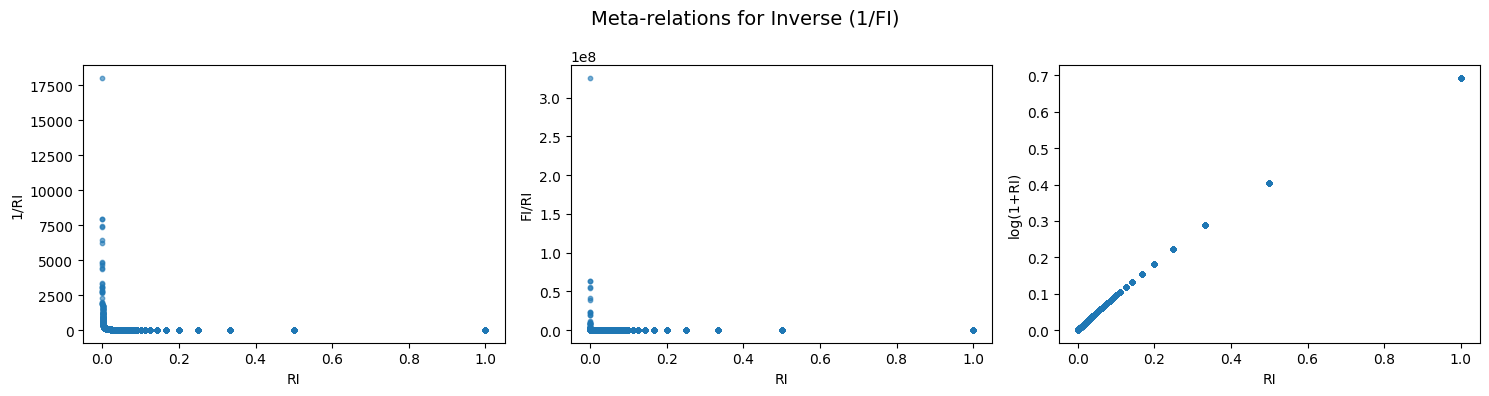

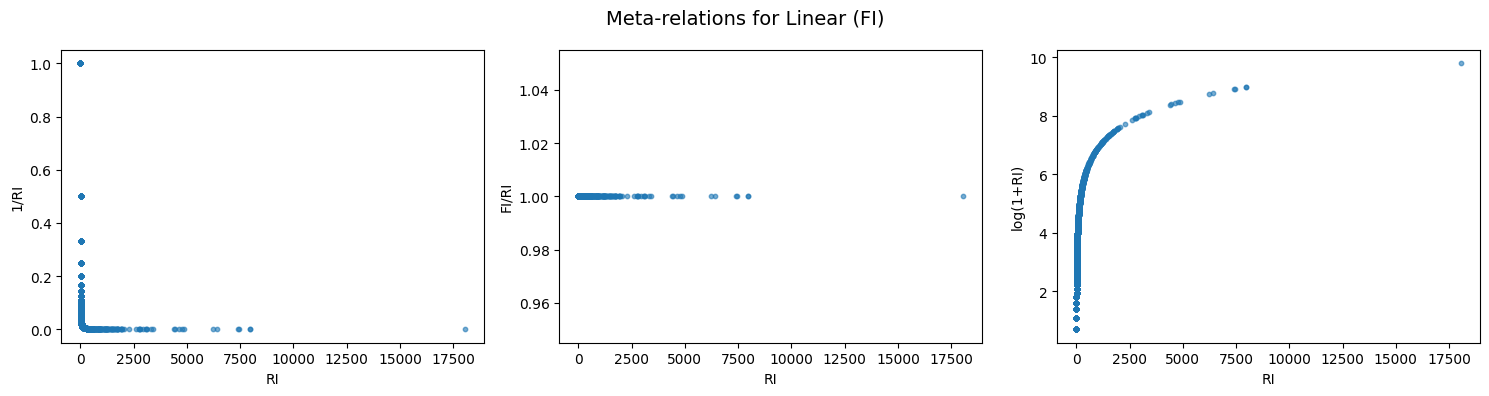

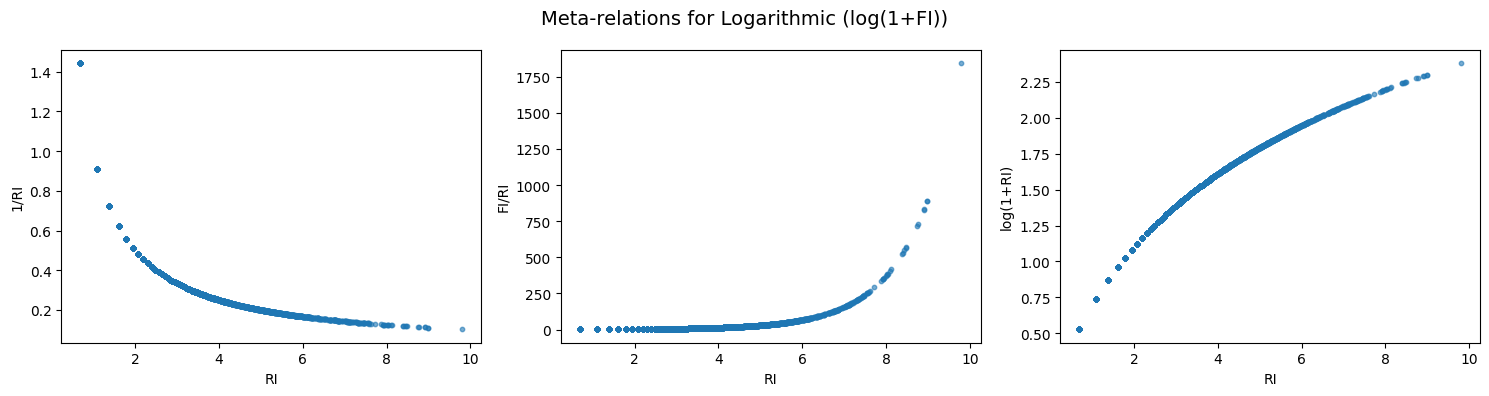

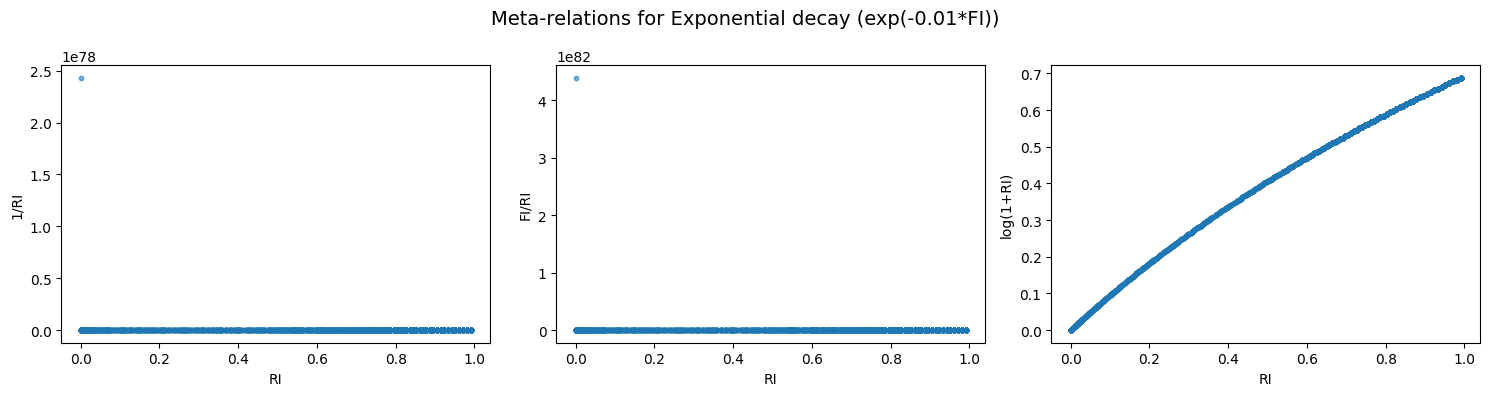

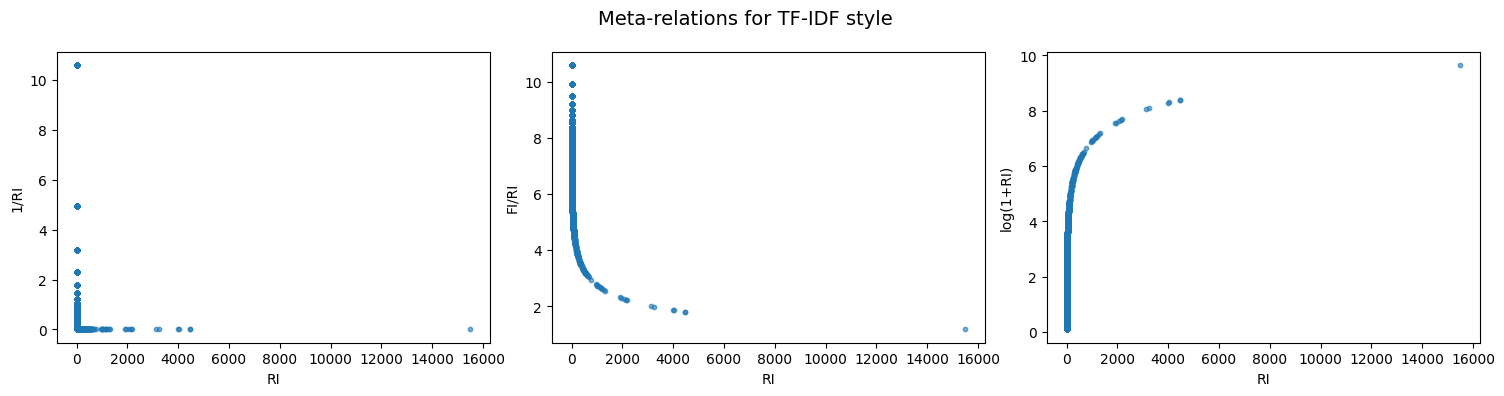

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load recipes
with open("train.json", "r") as f:
    recipes = json.load(f)

# Count ingredient frequency
ingredient_counts = Counter()
for recipe in recipes:
    ingredient_counts.update(recipe["ingredients"])

freqs = np.array(list(ingredient_counts.values()))
N = len(recipes)

# Relevance functions
relations = {
    "Inverse (1/FI)": 1 / freqs,
    "Linear (FI)": freqs,
    "Logarithmic (log(1+FI))": np.log1p(freqs),
    "Exponential decay (exp(-0.01*FI))": np.exp(-0.01 * freqs),
    "TF-IDF style": freqs / np.log1p(N / freqs)
}

# --- Meta-relation plots ---
def plot_meta_relations(relations):
    for label, RI in relations.items():
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"Meta-relations for {label}", fontsize=14)

        # 1/RI vs RI
        axs[0].scatter(RI, 1/RI, s=10, alpha=0.6)
        axs[0].set_xlabel("RI")
        axs[0].set_ylabel("1/RI")

        # FI/RI vs RI
        axs[1].scatter(RI, freqs/RI, s=10, alpha=0.6)
        axs[1].set_xlabel("RI")
        axs[1].set_ylabel("FI/RI")

        # log(1+RI) vs RI
        axs[2].scatter(RI, np.log1p(RI), s=10, alpha=0.6)
        axs[2].set_xlabel("RI")
        axs[2].set_ylabel("log(1+RI)")

        plt.tight_layout()
        plt.show()

# Run it
plot_meta_relations(relations)


In [5]:
import json
import pandas as pd

# --- Step 1: Load JSON ---
with open("train.json", "r") as f:
    data = json.load(f)

# JSON assumed structure:
# [
#   {"id": "1", "cuisine": "italian", "ingredients": ["tomato", "basil", "cheese"]},
#   {"id": "2", "cuisine": "indian", "ingredients": ["chili", "onion", "garlic"]},
#   ...
# ]

print("Sample recipe:", data[0])

# --- Step 2: Flatten ingredients ---
all_ingredients = []
for recipe in data:
    all_ingredients.extend(recipe["ingredients"])

# --- Step 3: Compute Frequency (FI) ---
ingredient_freq = pd.Series(all_ingredients).value_counts()

# --- Step 4: Compute Relevance (RI = 1/FI) ---
ingredient_relevance = 1 / ingredient_freq

# --- Step 5: Create dataframe ---
ri_df = pd.DataFrame({
    "Ingredient": ingredient_freq.index,
    "Frequency (FI)": ingredient_freq.values,
    "Relevance (RI)": ingredient_relevance.values
})

# --- Step 6: Display ---
print("\n🔹 Top 10 Rare (High Relevance) Ingredients:")
print(ri_df.sort_values("Relevance (RI)", ascending=False).head(10))

print("\n🔹 Top 10 Common (Low Relevance) Ingredients:")
print(ri_df.sort_values("Relevance (RI)", ascending=True).head(10))

# --- Optional: Save results ---
ri_df.to_csv("ingredient_relevance.json", index=False)


Sample recipe: {'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}

🔹 Top 10 Rare (High Relevance) Ingredients:
                                             Ingredient  Frequency (FI)  \
6713                            crushed cheese crackers               1   
5545                                              speck               1   
5534                                 jerk rub seasoning               1   
5535                       english breakfast tea leaves               1   
5536                                tandoori masala mix               1   
5537                                           rice mix               1   
5538                                      asti spumante               1   
5539                                    heirloom squash               1   
5540  Crystal Farms Reduced Fat Shredded Marble Jack...               

In [3]:
import json
import numpy as np
import pandas as pd
from collections import Counter

# Load recipes
with open("train.json", "r") as f:
    recipes = json.load(f)

# Count ingredient frequency
ingredient_counts = Counter()
for recipe in recipes:
    ingredient_counts.update([ing.strip().lower() for ing in recipe["ingredients"]])

freqs = np.array(list(ingredient_counts.values()))
ingredient_list = list(ingredient_counts.keys())
N = len(recipes)

# Compute relevance for each relation
relations = {
    "Inverse (1/FI)": 1 / freqs,
    "Linear (FI)": freqs,
    "Logarithmic (log(1+FI))": np.log1p(freqs),
    "Exponential decay (exp(-0.01*FI))": np.exp(-0.01 * freqs),
    "TF-IDF style": freqs / np.log1p(N / freqs)
}

# Collect top 5 for each relation
result = []
for label, RI in relations.items():
    top5_idx = np.argsort(RI)[-5:][::-1]
    for rank, idx in enumerate(top5_idx, 1):
        result.append({
            "Relation": label,
            "Rank": rank,
            "Ingredient": ingredient_list[idx],
            "Score": RI[idx]
        })

# Convert to DataFrame and save
df_top5 = pd.DataFrame(result)
df_top5.to_csv("top5_ingredients_by_relation.csv", index=False)


In [6]:
import pandas as pd

# Assuming df_top5 is already created as in your previous code
def format_ing(row):
    return f"{row['Ingredient']} ({row['Score']:.4f})"

pivot = df_top5.copy()
pivot["Ingredient_Score"] = pivot.apply(format_ing, axis=1)
table = pivot.pivot(index="Rank", columns="Relation", values="Ingredient_Score")

# Save as CSV (readable in Excel)
table.to_csv("top5_ingredients_by_relation_readable.csv")

# Display as a pretty table in notebook
from IPython.display import display
display(table)

Relation,Exponential decay (exp(-0.01*FI)),Inverse (1/FI),Linear (FI),Logarithmic (log(1+FI)),TF-IDF style
Rank,,,,,
1,crushed cheese crackers (0.9900),crushed cheese crackers (1.0000),salt (18049.0000),salt (9.8009),salt (15502.0671)
2,frozen fruit (0.9900),frozen fruit (1.0000),onions (7972.0000),onions (8.9838),onions (4453.7311)
3,small potatoes (0.9900),small potatoes (1.0000),olive oil (7972.0000),olive oil (8.9838),olive oil (4453.7311)
4,rose hip tea bags (0.9900),rose hip tea bags (1.0000),water (7457.0000),water (8.9170),water (4039.7698)
5,whole garam masala (0.9900),whole garam masala (1.0000),garlic (7380.0000),garlic (8.9067),garlic (3979.1977)


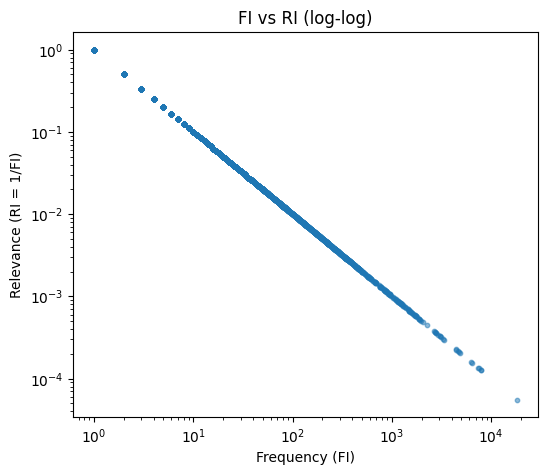

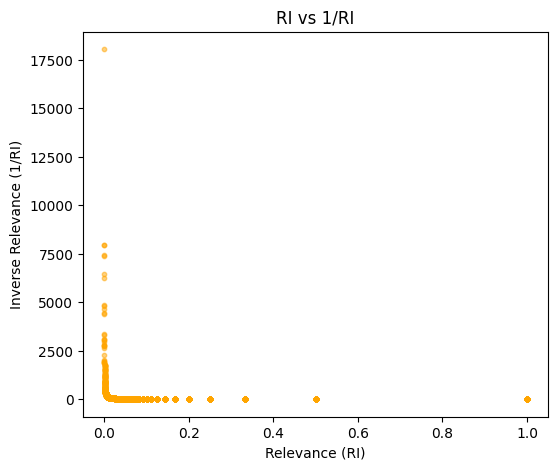

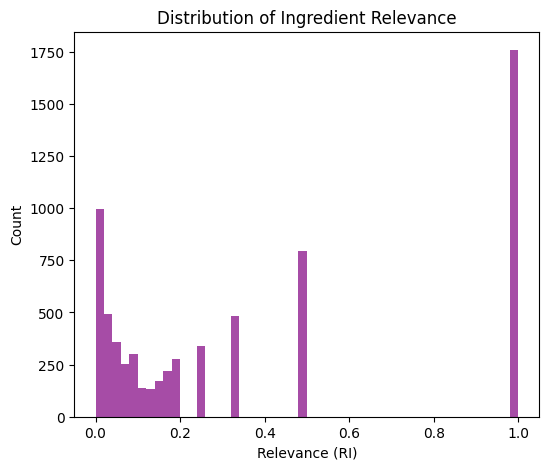

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract arrays
FI = ri_df["Frequency (FI)"].values
RI = ri_df["Relevance (RI)"].values

# --- 1. FI vs RI (scatter log-log) ---
plt.figure(figsize=(6,5))
plt.scatter(FI, RI, alpha=0.5, s=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (FI)")
plt.ylabel("Relevance (RI = 1/FI)")
plt.title("FI vs RI (log-log)")
plt.show()

# --- 2. RI vs 1/RI ---
plt.figure(figsize=(6,5))
plt.scatter(RI, 1/RI, alpha=0.5, s=10, color="orange")
plt.xlabel("Relevance (RI)")
plt.ylabel("Inverse Relevance (1/RI)")
plt.title("RI vs 1/RI")
plt.show()

# --- 3. Histogram of RI ---
plt.figure(figsize=(6,5))
plt.hist(RI, bins=50, color="purple", alpha=0.7)
plt.xlabel("Relevance (RI)")
plt.ylabel("Count")
plt.title("Distribution of Ingredient Relevance")
plt.show()


In [1]:
import pyopencl as cl

platforms = cl.get_platforms()
for platform in platforms:
    print("Platform:", platform.name)
    for device in platform.get_devices():
        print("  Device:", device.name, "| Type:", cl.device_type.to_string(device.type))


Platform: AMD Accelerated Parallel Processing
  Device: gfx1032 | Type: ALL | GPU


Backbone Extraction Filters (from code):

1. Ingredient Relevance Filter:
   - Only ingredients with Relevance (RI) ≥ 0.1 are included.
   - Example: If RI_THRESHOLD = 0.1, only ingredients above this value are kept.

2. Co-occurrence Filter:
   - Only pairs of relevant ingredients that co-occur in at least 1 recipe are considered as edges.

3. Disparity Filter (Statistical Edge Filter):
   - For each node with degree > 1, keep edge (u, v) if:
     alpha_ij = 1 - (1 - w/s)^(k-1) < alpha
     where:
       - w = edge weight between u and v
       - s = sum of weights of all edges from u
       - k = degree of u
       - alpha = 0.5 (default in code)
   - Lower alpha keeps fewer, more significant edges.

Result: The backbone network contains only statistically significant ingredient

In [25]:
import json
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

# --- Load recipes ---
with open("train.json", "r") as f:
    recipes = json.load(f)

# --- Load relevance ---
ri_df = pd.read_csv("ingredient_relevance.csv")
ri_dict = dict(zip(ri_df["Ingredient"].str.strip().str.lower(), ri_df["Relevance (RI)"]))

# --- Keep only relevant ingredients ---
RI_THRESHOLD = 0.1   # adjust threshold
relevant_ings = {ing for ing, ri in ri_dict.items() if ri >= RI_THRESHOLD}
print("Relevant ingredients:", len(relevant_ings))

# --- Build co-occurrence counts ---
edge_weights = defaultdict(int)
for recipe in tqdm(recipes):
    ings = [ing.strip().lower() for ing in recipe["ingredients"] if ing.strip().lower() in relevant_ings]
    for u, v in combinations(sorted(set(ings)), 2):
        edge_weights[(u, v)] += 1

print("Raw edges:", len(edge_weights))

# --- Build base graph ---
G = nx.Graph()
G.add_nodes_from(relevant_ings)
for (u, v), w in edge_weights.items():
    G.add_edge(u, v, weight=w)

print("Nodes in G:", G.number_of_nodes())
print("Edges before pruning:", G.number_of_edges())

# --- Corrected Disparity Filter Implementation ---
def disparity_filter(G, alpha=0.5):
    """
    Disparity filter backbone extraction (improved for sparse graphs)
    Keeps edges that are statistically significant.
    """
    if not nx.is_weighted(G):
        raise ValueError("Graph must be weighted")

    B = nx.Graph()

    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        k = len(neighbors)
        if k > 1:
            s = sum(G[u][v]['weight'] for v in neighbors)
            for v in neighbors:
                w = G[u][v]['weight']
                # Correct formula for significance
                alpha_ij = 1 - (1 - w / s) ** (k - 1)
                if alpha_ij < alpha:
                    # Add edge only if not already added (since undirected)
                    if not B.has_edge(u, v):
                        B.add_edge(u, v, **G[u][v])

    # Add only nodes that have edges
    B.add_nodes_from([n for n in B.nodes() if B.degree(n) > 0])

    return B

# --- Apply corrected disparity filter ---
print("Applying corrected disparity filter backbone...")
B = disparity_filter(G, alpha=0.5)   # adjust alpha (higher → more edges)

print("Nodes in backbone:", B.number_of_nodes())
print("Edges in backbone:", B.number_of_edges())

# --- Save backbone graph ---
nx.write_graphml(B, "ingredient_backbone.graphml")
print("Backbone graph saved ✅")


Relevant ingredients: 4434


100%|██████████| 39774/39774 [00:00<00:00, 421897.68it/s]

Raw edges: 3474
Nodes in G: 4434
Edges before pruning: 3474
Applying corrected disparity filter backbone...
Nodes in backbone: 240
Edges in backbone: 192
Backbone graph saved ✅


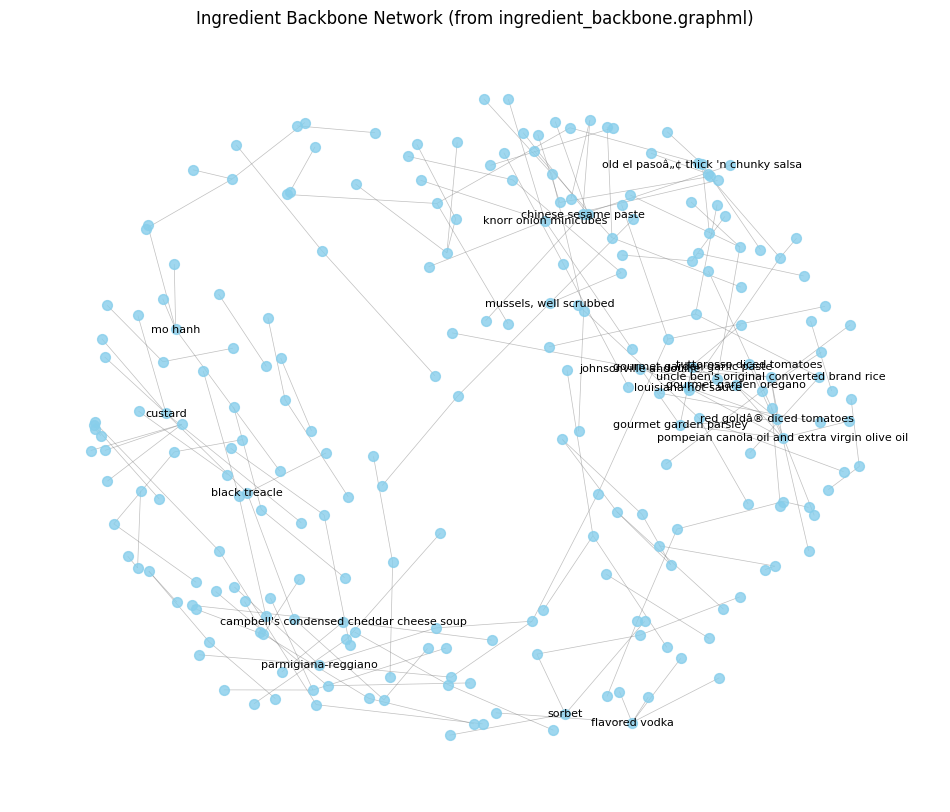

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Load backbone graph ---
B = nx.read_graphml("ingredient_backbone.graphml")

# Layout (spring layout for clusters)
pos = nx.spring_layout(B, seed=42, k=0.3)

plt.figure(figsize=(12, 10))

# Draw nodes
nx.draw_networkx_nodes(
    B, pos,
    node_size=50,
    node_color="skyblue",
    alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(
    B, pos,
    width=0.5,
    alpha=0.5,
    edge_color="gray"
)

# Label only top-degree nodes
top_nodes = sorted(B.degree, key=lambda x: x[1], reverse=True)[:20]
labels = {n: n for n, _ in top_nodes}
nx.draw_networkx_labels(B, pos, labels, font_size=8)

plt.title("Ingredient Backbone Network (from ingredient_backbone.graphml)")
plt.axis("off")
plt.show()


In [2]:
import networkx as nx

# --- Load backbone graph ---
B = nx.read_graphml("ingredient_backbone.graphml")

print("Nodes:", B.number_of_nodes())
print("Edges:", B.number_of_edges())

# --- Top ingredients by degree (most connected) ---
degree_sorted = sorted(B.degree, key=lambda x: x[1], reverse=True)
print("\nTop 10 most connected ingredients:")
for ing, deg in degree_sorted[:10]:
    print(f"{ing}: {deg} connections")

# --- Top ingredients by weighted degree (strength) ---
strength = {}
for n in B.nodes():
    strength[n] = sum(B[n][nbr]['weight'] for nbr in B.neighbors(n))

strength_sorted = sorted(strength.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 strongest ingredients (sum of edge weights):")
for ing, s in strength_sorted[:10]:
    print(f"{ing}: {s}")

# --- Communities (Louvain clustering if available) ---
try:
    import community as community_louvain
    partition = community_louvain.best_partition(B)
    print("\nExample communities (first 5 nodes with their cluster IDs):")
    for i, (node, com) in enumerate(list(partition.items())[:10]):
        print(f"{node}: Cluster {com}")
except ImportError:
    print("\nInstall python-louvain to detect communities.")


Nodes: 240
Edges: 192

Top 10 most connected ingredients:
pompeian canola oil and extra virgin olive oil: 7 connections
johnsonville andouille: 6 connections
custard: 5 connections
flavored vodka: 5 connections
knorr onion minicubes: 5 connections
gourmet garden garlic paste: 5 connections
mo hanh: 4 connections
gourmet garden oregano: 4 connections
gourmet garden parsley: 4 connections
louisiana hot sauce: 4 connections

Top 10 strongest ingredients (sum of edge weights):
pompeian canola oil and extra virgin olive oil: 7
johnsonville andouille: 6
custard: 5
flavored vodka: 5
knorr onion minicubes: 5
gourmet garden garlic paste: 5
mo hanh: 4
gourmet garden oregano: 4
gourmet garden parsley: 4
louisiana hot sauce: 4

Example communities (first 5 nodes with their cluster IDs):
herdez salsa verde: Cluster 0
carne asada: Cluster 0
kochujang: Cluster 1
tripe: Cluster 1
raw cane sugar: Cluster 1
black treacle: Cluster 4
coffee extract: Cluster 4
custard: Cluster 4
soft margarine: Cluster 4
o

Relevant ingredients: 4434


100%|██████████| 39774/39774 [00:00<00:00, 420719.83it/s]

Raw edges: 3474
Nodes in G: 4434
Edges before pruning: 3474
Backbone edges: 192


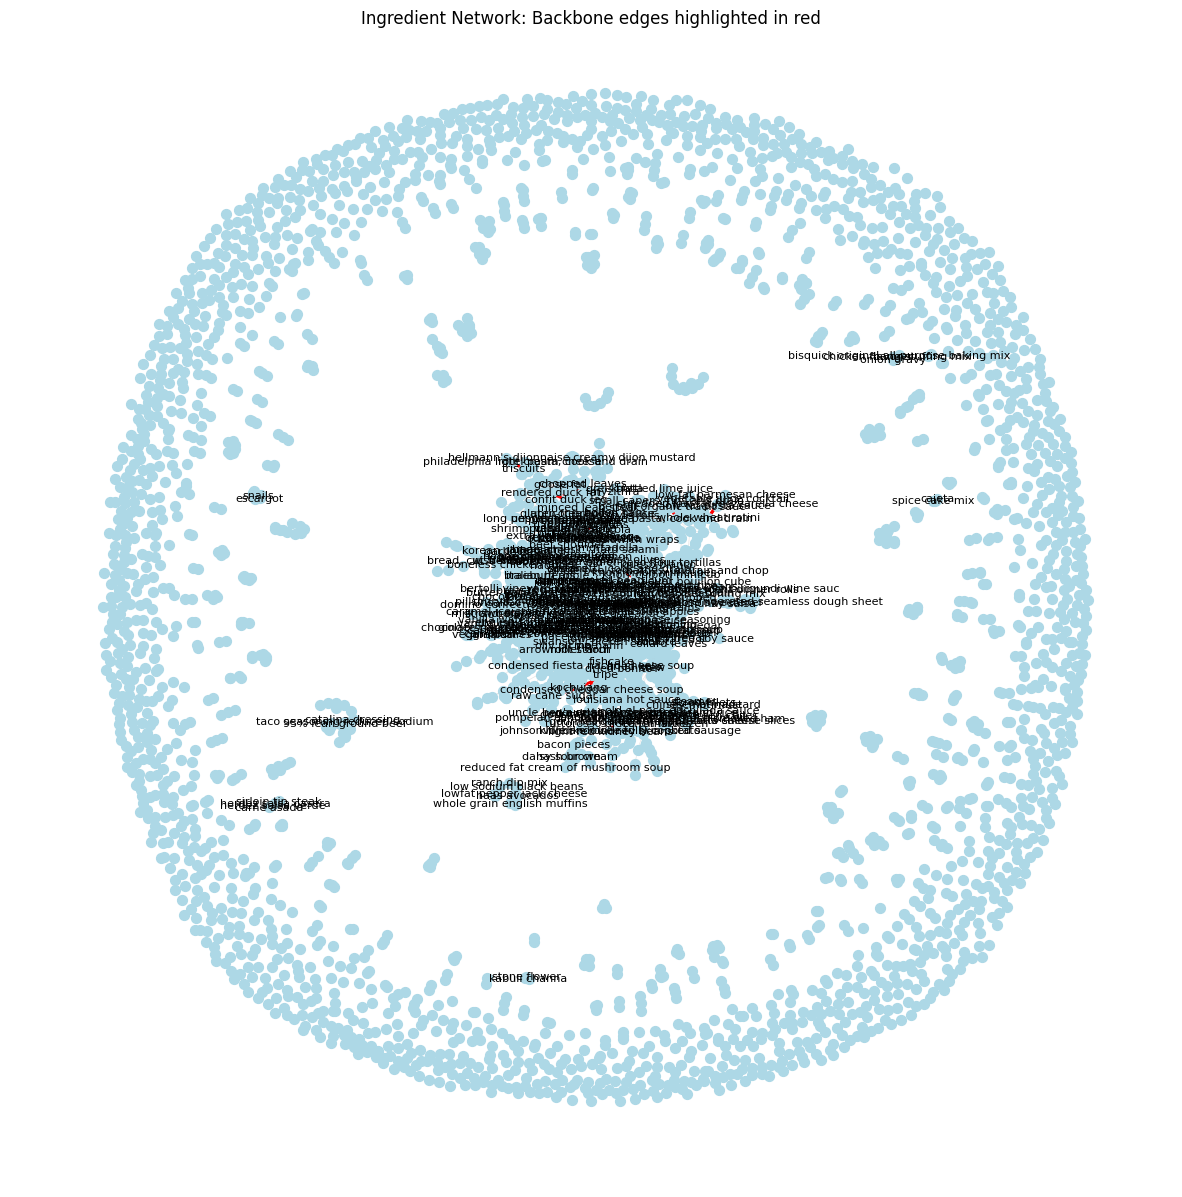

In [29]:
import json
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Load recipes ---
with open("train.json", "r") as f:
    recipes = json.load(f)

# --- Load relevance ---
ri_df = pd.read_csv("ingredient_relevance.csv")
ri_dict = dict(zip(ri_df["Ingredient"].str.strip().str.lower(), ri_df["Relevance (RI)"]))

# --- Keep only relevant ingredients ---
RI_THRESHOLD = 0.1
relevant_ings = {ing for ing, ri in ri_dict.items() if ri >= RI_THRESHOLD}
print("Relevant ingredients:", len(relevant_ings))

# --- Build co-occurrence counts ---
edge_weights = defaultdict(int)
for recipe in tqdm(recipes):
    ings = [ing.strip().lower() for ing in recipe["ingredients"] if ing.strip().lower() in relevant_ings]
    for u, v in combinations(sorted(set(ings)), 2):
        edge_weights[(u, v)] += 1

print("Raw edges:", len(edge_weights))

# --- Build base graph ---
G = nx.Graph()
G.add_nodes_from(relevant_ings)
for (u, v), w in edge_weights.items():
    G.add_edge(u, v, weight=w)

print("Nodes in G:", G.number_of_nodes())
print("Edges before pruning:", G.number_of_edges())

# --- Disparity filter (same as before) ---
def disparity_filter(G, alpha=0.5):
    B = nx.Graph()
    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        k = len(neighbors)
        if k > 1:
            s = sum(G[u][v]['weight'] for v in neighbors)
            for v in neighbors:
                w = G[u][v]['weight']
                alpha_ij = 1 - (1 - w / s) ** (k - 1)
                if alpha_ij < alpha:
                    if not B.has_edge(u, v):
                        B.add_edge(u, v, **G[u][v])
    return B

# --- Apply disparity filter ---
B = disparity_filter(G, alpha=0.5)
print("Backbone edges:", B.number_of_edges())

# --- Visualization: full graph with backbone highlighted ---
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')

# Draw all edges (thin, gray)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color='gray')

# Draw backbone edges (thicker, red)
nx.draw_networkx_edges(B, pos, width=2, edge_color='red')

# Draw labels for backbone nodes only (optional)
nx.draw_networkx_labels(B, pos, font_size=8)

plt.title("Ingredient Network: Backbone edges highlighted in red")
plt.axis('off')
plt.show()
